# Prova final da disciplina Análise Estatística de Dados e Informações - PPCA

Prof. João Gabriel de Moraes Souza

Aluno: Demétrius de Almeida Jubé

# Análise financeira de um portifólio diversificado de empresas brasileiras

Para a nossa análise, serão consideradas as ações de quatro empresas que atuam na B3, todas de seguimentos diferentes, com o objetivo de diluir o risco dos investimentos:

| Empresa | Código | Destaque ou perfil corporativo |
|:---|:---:|---|
| JBS | JBSS3.SA | JBS S.A. é uma empresa brasileira do setor de alimentos fundada em 1953 em Goiás. A companhia opera no processamento de carnes bovina, suína, ovina, de frango, de peixe e plant-based, além de atuar no processamento de couros. |
| Grendene | GRND3.SA | Grendene é uma empresa brasileira do setor calçadista dona das marcas: Grendha, Melissa, Ipanema, Rider, Zaxy, Cartago, Pega Forte e Zizou. |
| Totvs | TOTS3.SA | Totvs é uma empresa brasileira de software, com sede em São Paulo. A Totvs foi inicialmente formada a partir da fusão das empresas Microsiga e Logocenter. |
| Itaú Unibanco | ITUB4.SA | Itaú Unibanco, comumente chamado de Itaú, é o maior banco privado do Brasil e maior conglomerado financeiro do hemisfério sul.|

O índice que será utilizado para comparação será o IBOVESPA (^BVSP), e os objetivos da análise são os seguintes:

* Fazer a análise descritiva dos dados das ações
* Encontrar o portfólio que tenha o melhor Índice de Sharpe, juntamente com a Fronteira Eficiente
* Realizar ANOVA e Testes de Hipóteses
* Executar uma Regressão Linear e encontrar a relação de uma ação específica com o IBOVESPA
* Utilizar um modelo de previsão de Machine Learning para alguma ação

## Análise da performance da carteira

Para realização dos objetivos, vamos montar o ambiente e recuperar os dados que serão analisados:

### Setup do ambiente

Aqui, recuperaremos as bibliotecas que serão utilizadas para carregar e analisar os dados:

In [270]:
import pandas as pd
from pandas_datareader import data
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from scipy import stats
from scipy import optimize

pio.renderers.default = 'notebook_connected'

### Construindo a base de dados com as ações selecionadas

Faremos uma lista das ações que queremos verificar na carteira e buscaremos as informações no Yahoo Finance, utilizando a biblioteca do Panda Datareader para isso.

In [271]:
portfolio = ['JBSS3.SA', 'GRND3.SA', 'TOTS3.SA', 'ITUB4.SA']
indice = '^BVSP'
acoes = portfolio.copy()
acoes.append(indice)
print('Ações que serão pesquisadas:')
acoes

Ações que serão pesquisadas:


['JBSS3.SA', 'GRND3.SA', 'TOTS3.SA', 'ITUB4.SA', '^BVSP']

In [272]:
acoes_df = pd.DataFrame()
for acao in acoes:
    acoes_df[acao] = data.DataReader(acao,
                                     data_source='yahoo', start='2015-01-01')['Close']

O resultado da pesquisa pode ser verificado abaixo:

In [273]:
acoes_df

,JBSS3.SA,GRND3.SA,TOTS3.SA,ITUB4.SA,^BVSP
Date,,,,,
2015-01-02,10.550000,4.966666,11.910702,18.639118,48512.0
2015-01-05,10.600000,4.883333,11.544731,18.732782,47517.0
2015-01-06,10.350000,4.783333,10.822770,19.035812,48001.0
2015-01-07,10.640000,5.160000,10.746248,19.724518,49463.0
2015-01-08,10.730000,5.133333,10.995774,20.033056,49943.0
...,...,...,...,...,...
2022-09-26,25.709999,7.080000,28.219999,27.690001,109114.0
2022-09-27,25.920000,7.020000,28.730000,27.530001,108376.0
2022-09-28,25.379999,6.990000,29.209999,27.520000,108451.0


Por conta da cisão do Pão de Açucar e do Assaí em março de 2021, os dados recuperados estão vindo a partir dessa data.

Será necessário incluir um índice independente na lista, pois a pesquisa coloca como chave de cada registro a data. É possível fazer isso utilizando a função `reset_index` do `DataFrame`. Ao utilizarmos o argumento `inplace=True`, nós garantimos que não há nenhuma perda de dados.

In [274]:
acoes_df.reset_index(inplace=True)
acoes_df

,Date,JBSS3.SA,GRND3.SA,TOTS3.SA,ITUB4.SA,^BVSP
0,2015-01-02,10.550000,4.966666,11.910702,18.639118,48512.0
1,2015-01-05,10.600000,4.883333,11.544731,18.732782,47517.0
2,2015-01-06,10.350000,4.783333,10.822770,19.035812,48001.0
3,2015-01-07,10.640000,5.160000,10.746248,19.724518,49463.0
4,2015-01-08,10.730000,5.133333,10.995774,20.033056,49943.0
...,...,...,...,...,...,...
1922,2022-09-26,25.709999,7.080000,28.219999,27.690001,109114.0
1923,2022-09-27,25.920000,7.020000,28.730000,27.530001,108376.0
1924,2022-09-28,25.379999,6.990000,29.209999,27.520000,108451.0
1925,2022-09-29,25.320000,6.990000,28.570000,27.930000,107664.0


### Visualização dos Dados

A Biblioteca Ploty, do Python, nos permite visualizar, de forma gráfica, os dados que recuperamos. Vamos ver o histórico de preços das ações no decorrer do tempo:

In [279]:
figuraHistorico = px.line(title = 'Histórico do preço das ações do portfólio')
acoes_historico = acoes_df.copy()
acoes_historico.drop(['^BVSP'], axis=1, inplace=True)
for i in acoes_historico.columns[1:]:
  figuraHistorico.add_scatter(x = acoes_historico["Date"] ,y = acoes_historico[i], name = i)
figuraHistorico.show()

É possível observar no gráfico o impacto da pandemia de Covid 19 nos papeis. Do portfólio, apenas a Grendene teve uma relativa estabilidade, enquanto as outras ações sofrearam oscilações expressivas.

## Taxa de Retorno de Ações

Um dos indicadores que vamos analisar é a taxa de retorno das ações da carteira. Ela basicamente se define como a razão entre o valor atual e o valor anterior. Com os dados que temos, podemos acompanhar a evolução da taxa de retorno comparando o valor de fechamento de um dia com o valor do fechamento do dia anterior. Como há um intervalo de tempo entre esses dois pontos, essa diferença é abrupta, e é possível suavizá-la com o uso do `log`.

A expressão da Valor Esperado da taxa de retorno pode ser descrita assim:

$$ \mathbb{E} [ R_i] = log \left( \frac{P_t}{P_{t-1}} \right) $$

Como temos os dados variando no tempo, é possível fazer esse cálculo para cada registro. Felizmente não será necessário fazer a iteração manual dos dados, pois a  biblioteca `NumPy` tem, através da função `log`, a capacidade de fazer a operação utilizando dois `DataFrame`s, utilizando como argumento os de mesmo índice.

Já temos o `DataFrame` com os dados originais, e só nos falta montar outro com os dados do dia anterior, com o mesmo índice dos dados originais, para poder fazer o cálculo. O artifício que vamos usar para isso é a função `shift` do `DataFrame`. Essa função adiciona uma quantidade de registros no topo do `DataFrame`. Aplicando isso no nosso conjunto de dados, conseguiremos uma cópia dos dados do dia anterior, alinhados com o índice dos nossos dados originais.

O primeiro passo é copiar o `DataFrame` das ações:

In [280]:
dataset = acoes_df.copy()
dataset

,Date,JBSS3.SA,GRND3.SA,TOTS3.SA,ITUB4.SA,^BVSP
0,2015-01-02,10.550000,4.966666,11.910702,18.639118,48512.0
1,2015-01-05,10.600000,4.883333,11.544731,18.732782,47517.0
2,2015-01-06,10.350000,4.783333,10.822770,19.035812,48001.0
3,2015-01-07,10.640000,5.160000,10.746248,19.724518,49463.0
4,2015-01-08,10.730000,5.133333,10.995774,20.033056,49943.0
...,...,...,...,...,...,...
1922,2022-09-26,25.709999,7.080000,28.219999,27.690001,109114.0
1923,2022-09-27,25.920000,7.020000,28.730000,27.530001,108376.0
1924,2022-09-28,25.379999,6.990000,29.209999,27.520000,108451.0
1925,2022-09-29,25.320000,6.990000,28.570000,27.930000,107664.0


Com a cópia, vamos retirar a coluna `Date`, pois ela não será usada no cálculo: 

In [281]:
dataset.drop(labels = ['Date'], axis=1, inplace=True)
dataset

,JBSS3.SA,GRND3.SA,TOTS3.SA,ITUB4.SA,^BVSP
0,10.550000,4.966666,11.910702,18.639118,48512.0
1,10.600000,4.883333,11.544731,18.732782,47517.0
2,10.350000,4.783333,10.822770,19.035812,48001.0
3,10.640000,5.160000,10.746248,19.724518,49463.0
4,10.730000,5.133333,10.995774,20.033056,49943.0
...,...,...,...,...,...
1922,25.709999,7.080000,28.219999,27.690001,109114.0
1923,25.920000,7.020000,28.730000,27.530001,108376.0
1924,25.379999,6.990000,29.209999,27.520000,108451.0
1925,25.320000,6.990000,28.570000,27.930000,107664.0


Realizamos o `shift` para verificar o funcionamento e constatar que a primeira linha foi deslocada:

In [282]:
dataset.shift(1)

,JBSS3.SA,GRND3.SA,TOTS3.SA,ITUB4.SA,^BVSP
0,NaN,NaN,NaN,NaN,NaN
1,10.550000,4.966666,11.910702,18.639118,48512.0
2,10.600000,4.883333,11.544731,18.732782,47517.0
3,10.350000,4.783333,10.822770,19.035812,48001.0
4,10.640000,5.160000,10.746248,19.724518,49463.0
...,...,...,...,...,...
1922,26.280001,7.320000,29.570000,28.299999,111716.0
1923,25.709999,7.080000,28.219999,27.690001,109114.0
1924,25.920000,7.020000,28.730000,27.530001,108376.0
1925,25.379999,6.990000,29.209999,27.520000,108451.0


O resultado das taxas de retorno pode ser visto abaixo:

In [283]:
taxas_retorno = np.log(dataset / dataset.shift(1))
taxas_retorno.fillna(0, inplace=True)
taxas_retorno

,JBSS3.SA,GRND3.SA,TOTS3.SA,ITUB4.SA,^BVSP
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.004728,-0.016921,-0.031208,0.005013,-0.020724
2,-0.023867,-0.020690,-0.064577,0.016047,0.010134
3,0.027634,0.075799,-0.007096,0.035540,0.030003
4,0.008423,-0.005181,0.022954,0.015521,0.009657
...,...,...,...,...,...
1922,-0.021928,-0.033336,-0.046729,-0.021790,-0.023567
1923,0.008135,-0.008511,0.017911,-0.005795,-0.006787
1924,-0.021053,-0.004283,0.016569,-0.000363,0.000692
1925,-0.002367,0.000000,-0.022154,0.014788,-0.007283


A função `describe` do `DataFrame` pode nos proporcionar várias informações estatísticas importantes sobre as taxas de retorno:

In [284]:
taxas_retorno.describe()

,JBSS3.SA,GRND3.SA,TOTS3.SA,ITUB4.SA,^BVSP
count,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000
mean,0.000450,0.000183,0.000468,0.000212,0.000392
std,0.030575,0.020784,0.024602,0.020904,0.016264
min,-0.376051,-0.118365,-0.166569,-0.198015,-0.159930
25%,-0.015353,-0.010602,-0.012566,-0.011323,-0.007714
50%,0.000000,0.000000,0.000000,0.000000,0.000536
75%,0.015078,0.011222,0.013889,0.011643,0.009225
max,0.219915,0.095964,0.180650,0.104894,0.130223


Agora podemos reconstruir os dados de retorno das ações, incluindo a data de cada registro, permitindo a visualização do comportamento do retorno ao longo do tempo. Para isso, podemos selecionar a coluna de data do `DataFrame` original e juntá-lo com a matriz das taxas de retorno. 

In [180]:
dataset_date = acoes_df.copy()
date = dataset_date.filter(["Date"]) 
date

,Date
0,2015-01-02
1,2015-01-05
2,2015-01-06
3,2015-01-07
4,2015-01-08
...,...
1922,2022-09-26
1923,2022-09-27
1924,2022-09-28
1925,2022-09-29


In [285]:
taxas_retorno_date = pd.concat([date, taxas_retorno], axis=1)
taxas_retorno_date

,Date,JBSS3.SA,GRND3.SA,TOTS3.SA,ITUB4.SA,^BVSP
0,2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000
1,2015-01-05,0.004728,-0.016921,-0.031208,0.005013,-0.020724
2,2015-01-06,-0.023867,-0.020690,-0.064577,0.016047,0.010134
3,2015-01-07,0.027634,0.075799,-0.007096,0.035540,0.030003
4,2015-01-08,0.008423,-0.005181,0.022954,0.015521,0.009657
...,...,...,...,...,...,...
1922,2022-09-26,-0.021928,-0.033336,-0.046729,-0.021790,-0.023567
1923,2022-09-27,0.008135,-0.008511,0.017911,-0.005795,-0.006787
1924,2022-09-28,-0.021053,-0.004283,0.016569,-0.000363,0.000692
1925,2022-09-29,-0.002367,0.000000,-0.022154,0.014788,-0.007283


E com isso, plotar um gráfico desse histórico:

In [182]:
figuraHistoricoRetorno = px.line(title = 'Histórico de retorno das ações')
for i in taxas_retorno_date.columns[1:]:
  figuraHistoricoRetorno.add_scatter(x = taxas_retorno_date["Date"] ,y = taxas_retorno_date[i], name = i)
figuraHistoricoRetorno.show()

### Covariância das taxas de retorno

O `DataFrame` nos permite verificar um dados interessante também: a *covariância* entre duas ações. No mercado financeiro, esse dado pode ser usado para avaliar como o  comportamento do preço de um ativo influencia no aumento ou diminuição de outro. No nosso caso, temos ao resultado abaixo: 

In [183]:
taxas_retorno.cov()

,JBSS3.SA,GRND3.SA,TOTS3.SA,ITUB4.SA,^BVSP
JBSS3.SA,0.000935,0.000129,0.000158,0.000154,0.000199
GRND3.SA,0.000129,0.000432,0.000181,0.000167,0.000162
TOTS3.SA,0.000158,0.000181,0.000605,0.000154,0.000198
ITUB4.SA,0.000154,0.000167,0.000154,0.000437,0.000270
^BVSP,0.000199,0.000162,0.000198,0.000270,0.000265


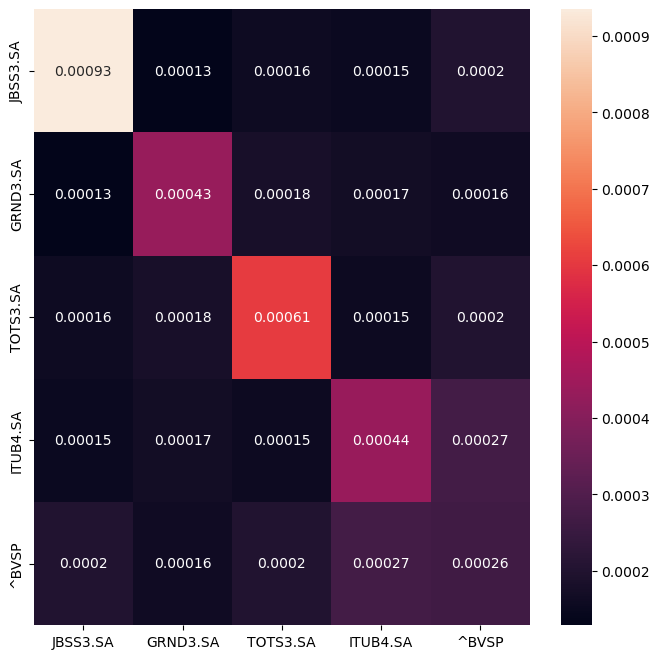

In [184]:
plt.figure(figsize=(8,8))
sns.heatmap(taxas_retorno.cov(), annot=True);

### Correlação entre as taxas de retorno

Além da covariância, outro indicador que é importante de analisar é a *correlação*. A correlação visa entender o comportamento entre dois ativos. Isso significa compreender se eles apresentam desempenho semelhante ou diferente, de acordo com os acontecimentos econômicos. No nosso exemplo, o seguinte cenário ocorre:

In [286]:
taxas_retorno.corr()

,JBSS3.SA,GRND3.SA,TOTS3.SA,ITUB4.SA,^BVSP
JBSS3.SA,1.000000,0.202427,0.209767,0.240524,0.400380
GRND3.SA,0.202427,1.000000,0.353560,0.384047,0.479383
TOTS3.SA,0.209767,0.353560,1.000000,0.299649,0.495888
ITUB4.SA,0.240524,0.384047,0.299649,1.000000,0.795375
^BVSP,0.400380,0.479383,0.495888,0.795375,1.000000


O mapa de calor pode nos dar uma representação gráfica melhor da situação:

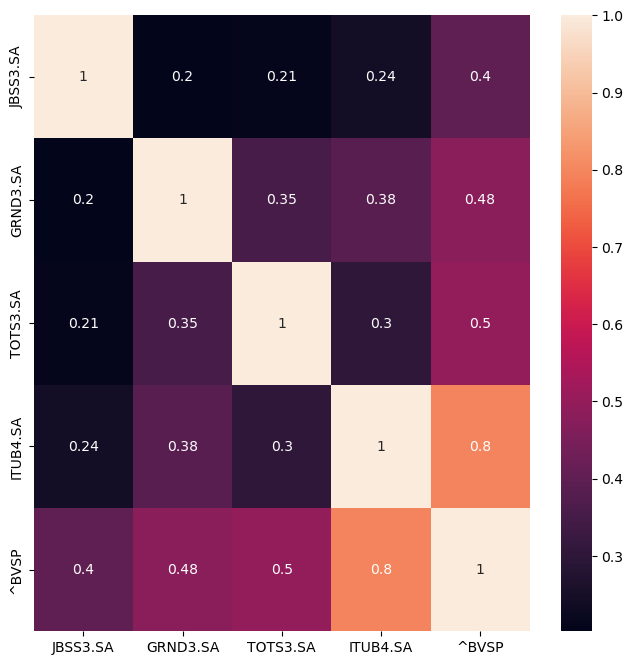

In [287]:
plt.figure(figsize=(8,8))
sns.heatmap(taxas_retorno.corr(), annot=True);

Percebemos que as ações do Itaú possuem uma forte correlação com o índice Bovespa, enquanto a os outros ativos da carteira têm uma correlação discreta.

## Montando uma Carteira de Ativos

Podemos verificar como uma carteira que contenha um conjunto de ações se comporta no decorrer do tempo, através da média das taxas de retorno de cada uma delas. Isso indicará a performance geral da carteira, e pode ser feito usando uma propriedade do `DataFrame`: ao fazermos uma operação aritmética no objeto, ele realiza essa operação em cada um dos elementos da matriz. É possível, também, filtrar cada uma das colunas do `DataFrame`, isolando as informações de uma ação específica.

Sendo assim, ao fazermos a soma de cada uma das ações e dividirmos pelo total de ações, teremos uma nova coluna (`CARTEIRA`) com a média da taxa de retorno diária do conjunto de ações, como representado abaixo:



In [187]:
# taxas_retorno_date["CARTEIRA"] = (taxas_retorno_date['AMAR3.SA'] + taxas_retorno_date['GUAR3.SA'] + 
#                                    taxas_retorno_date['ARZZ3.SA'] + taxas_retorno_date['LREN3.SA']  )/4
# portfolio = ['BBDC4.SA', 'BRSR6.SA', 'SANB11.SA', 'ITUB4.SA']
# portfolio = ['JBSS3.SA', 'GRND3.SA', 'CIEL3.SA', 'ITUB4.SA']
taxas_retorno_date["CARTEIRA"] = (taxas_retorno_date['JBSS3.SA'] + taxas_retorno_date['GRND3.SA'] + 
                                   taxas_retorno_date['TOTS3.SA'] + taxas_retorno_date['ITUB4.SA']  )/4

taxas_retorno_date

,Date,JBSS3.SA,GRND3.SA,TOTS3.SA,ITUB4.SA,^BVSP,CARTEIRA
0,2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2015-01-05,0.004728,-0.016921,-0.031208,0.005013,-0.020724,-0.009597
2,2015-01-06,-0.023867,-0.020690,-0.064577,0.016047,0.010134,-0.023272
3,2015-01-07,0.027634,0.075799,-0.007096,0.035540,0.030003,0.032969
4,2015-01-08,0.008423,-0.005181,0.022954,0.015521,0.009657,0.010429
...,...,...,...,...,...,...,...
1922,2022-09-26,-0.021928,-0.033336,-0.046729,-0.021790,-0.023567,-0.030946
1923,2022-09-27,0.008135,-0.008511,0.017911,-0.005795,-0.006787,0.002935
1924,2022-09-28,-0.021053,-0.004283,0.016569,-0.000363,0.000692,-0.002283
1925,2022-09-29,-0.002367,0.000000,-0.022154,0.014788,-0.007283,-0.002433


Temos agora a possibilidade de comparar a performance da carteira com o Índice Bovespa, selecionando as colunas `Data`, `CARTEIRA` e `^BVSP` do nosso conjunto de dados:

In [188]:
taxas_retorno_port = taxas_retorno_date.filter(["Date", "CARTEIRA", '^BVSP'])
taxas_retorno_port

,Date,CARTEIRA,^BVSP
0,2015-01-02,0.000000,0.000000
1,2015-01-05,-0.009597,-0.020724
2,2015-01-06,-0.023272,0.010134
3,2015-01-07,0.032969,0.030003
4,2015-01-08,0.010429,0.009657
...,...,...,...
1922,2022-09-26,-0.030946,-0.023567
1923,2022-09-27,0.002935,-0.006787
1924,2022-09-28,-0.002283,0.000692
1925,2022-09-29,-0.002433,-0.007283


E a representação gráfica fica conforme abaixo:

In [189]:
figuraComparacao = px.line(title = 'Comparação de retorno Carteira x Bovespa')
for i in taxas_retorno_port.columns[1:]:
  figuraComparacao.add_scatter(x = taxas_retorno_port["Date"] ,y = taxas_retorno_port[i], name = i)
figuraComparacao.add_hline(y = taxas_retorno_port['CARTEIRA'].mean(), line_color="green", line_dash="dot", )
figuraComparacao.show()

Percebemos que a carteira teve uma performance similar ao índice até o período de março de 2020, que foi quando a pandemia do Covid 19 começou a impactar os negócios no Brasil. A partir daí, temos uma performance da carteira um pouco melhor do que o índice, puxado, provavelmente, pelo desempenho da Arezzo. Podemos agora analisar o índice de correlação entre a carteira e o índice:

In [190]:
taxas_retorno_port_corr = taxas_retorno_date.filter(["CARTEIRA", "^BVSP"])
taxas_retorno_port_corr

,CARTEIRA,^BVSP
0,0.000000,0.000000
1,-0.009597,-0.020724
2,-0.023272,0.010134
3,0.032969,0.030003
4,0.010429,0.009657
...,...,...
1922,-0.030946,-0.023567
1923,0.002935,-0.006787
1924,-0.002283,0.000692
1925,-0.002433,-0.007283


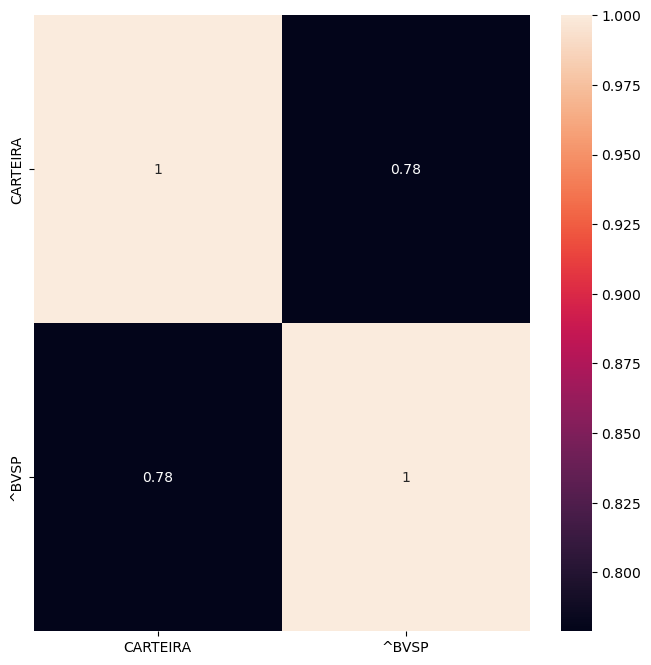

In [191]:
plt.figure(figsize=(8,8))
sns.heatmap(taxas_retorno_port_corr.corr(), annot=True);

## Alocação Aleatória de Ativos - Portfólio Markowitz

Harry Markowitz desenvolveu, nos anos 50, a Teoria Moderna do Portfólio. Essa teoria  apresenta um modelo de montagem de carteira que analisa os ativos com suposições de risco, retorno e correlação futuros. A partir dos dados é calculado uma série de possíveis alocações, entre essas possíveis alocações os portfólios que maximizam o retorno esperado e minimizam o risco formam a chamada fronteira eficiente. A TMP leva em consideração que o investidor sempre deseja ter o maior retorno possível dado determinado nível de tolerância ao risco.

O primeiro passo para simularmos um portfólio aleatório é retirarmos o índice BOVESPA do `DataFrame` que contém os dados, de forma que tenhamos apenas os dados das empresas:

In [192]:
acoes_port = acoes_df.copy()
acoes_port.drop(labels = ["^BVSP"], axis=1, inplace=True)
acoes_port

,Date,JBSS3.SA,GRND3.SA,TOTS3.SA,ITUB4.SA
0,2015-01-02,10.550000,4.966666,11.910702,18.639118
1,2015-01-05,10.600000,4.883333,11.544731,18.732782
2,2015-01-06,10.350000,4.783333,10.822770,19.035812
3,2015-01-07,10.640000,5.160000,10.746248,19.724518
4,2015-01-08,10.730000,5.133333,10.995774,20.033056
...,...,...,...,...,...
1922,2022-09-26,25.709999,7.080000,28.219999,27.690001
1923,2022-09-27,25.920000,7.020000,28.730000,27.530001
1924,2022-09-28,25.379999,6.990000,29.209999,27.520000
1925,2022-09-29,25.320000,6.990000,28.570000,27.930000


Definiremos agora um método que gera, de forma aleatória, um peso para cada uma das ações especificadas. Esse método também recebe como parâmetro o dinheiro investido, de forma que possa calcular o total do rendimento ao final daquela data. 

Há também dois parâmetros opcionais: o `seed`, que pode ser definido para modificar o número aleatório gerado, e um `Array` de melhores pesos, que é quando os pesos das ações podem ser definidos previamente. O retorno do método é uma tupla que contém:
- O `Dataset` com as taxas de retorno já modificadas de acordo com o peso
- A coluna `Date` separada
- Um `DataFrame` das ações com seus respectivos pesos
- A soma total do valor investido no decorrer do tempo. Esse número é recuperado acessando a coluna `soma valor` da última linha do `DataFrame`

A taxa de retorno também é calculada usando como base o valor total do dia dividido pelo valor total do dia anterior. Assim como feito anteriormente, a função `log` é usada para suavizar a curva.

In [193]:
def alocacao_ativos(dataset, dinheiro_total, seed = 0, melhores_pesos = []):
  dataset = dataset.copy()

  if seed != 0:
    np.random.seed(seed)

  if len(melhores_pesos) > 0:
    pesos = melhores_pesos
  else:  
    pesos = np.random.random(len(dataset.columns) - 1)
    #print(pesos, pesos.sum())
    pesos = pesos / pesos.sum()
    #print(pesos, pesos.sum())

  colunas = dataset.columns[1:]
  #print(colunas)
  for i in colunas:
    dataset[i] = (dataset[i] / dataset[i][0])

  for i, acao in enumerate(dataset.columns[1:]):
    #print(i, acao)
    dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total
  
  dataset['soma valor'] = dataset.sum(axis = 1)

  datas = dataset['Date']
  #print(datas)

  dataset.drop(labels = ['Date'], axis = 1, inplace = True)
  dataset['taxa retorno'] = 0.0

  for i in range(1, len(dataset)):
    dataset['taxa retorno'][i] = np.log(dataset['soma valor'][i] / dataset['soma valor'][i - 1]) * 100

  acoes_pesos = pd.DataFrame(data = {'Ações': colunas, 'Pesos': pesos})

  return dataset, datas, acoes_pesos, dataset.loc[len(dataset) - 1]['soma valor']

In [194]:
dataset, datas, acoes_pesos, soma_valor = alocacao_ativos(acoes_port, 10000, 3)

C:\Users\demet\AppData\Local\Temp\ipykernel_12028\2210113608.py:24: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [195]:
dataset

,JBSS3.SA,GRND3.SA,TOTS3.SA,ITUB4.SA,soma valor,taxa retorno
0,2672.896416,3436.479638,1411.694254,2478.929692,10000.000000,0.000000
1,2685.564220,3378.820799,1368.318253,2491.386660,9924.089931,-0.761997
2,2622.225443,3309.629663,1282.749136,2531.688464,9746.292707,-1.807815
3,2695.698414,3570.248859,1273.679521,2623.283590,10162.910383,4.185788
4,2718.500171,3551.797977,1303.254139,2664.317993,10237.870280,0.734876
...,...,...,...,...,...,...
1922,6513.759542,4898.713642,3344.724073,3682.661582,18439.858838,-2.947504
1923,6566.964365,4857.199159,3405.170922,3661.382229,18490.716675,0.275424
1924,6430.152376,4836.441752,3462.061994,3660.052238,18388.708361,-0.553200
1925,6414.951205,4836.441752,3386.207231,3714.580611,18352.180800,-0.198839


In [196]:
acoes_pesos

,Ações,Pesos
0,JBSS3.SA,0.267290
1,GRND3.SA,0.343648
2,TOTS3.SA,0.141169
3,ITUB4.SA,0.247893


In [197]:
datas

0      2015-01-02
1      2015-01-05
2      2015-01-06
3      2015-01-07
4      2015-01-08
          ...    
1922   2022-09-26
1923   2022-09-27
1924   2022-09-28
1925   2022-09-29
1926   2022-09-30
Name: Date, Length: 1927, dtype: datetime64[ns]

In [198]:
float(soma_valor).__round__(2)

18466.6

Com esses dados, podemos plotar o gráfico do retorno diário do portfólio (em %) e da evolução do patrimônio (em R$):

In [199]:
figura = px.line(x = datas, y = dataset['taxa retorno'], title = 'Retorno diário do portfólio',
                labels=dict(x="Data", y="Retorno %"))
figura.add_hline(y = dataset['taxa retorno'].mean(), line_color="red", line_dash="dot", )
figura.show()

In [200]:
figura = px.line(title = 'Evolução do patrimônio')
for i in dataset.drop(columns = ['soma valor', 'taxa retorno']).columns:
  figura.add_scatter(x = datas, y = dataset[i], name = i)
figura.show()

Já a perfomance combinada da carteira pode ser verificada no gráfico abaixo, onde `soma valor` é mostrado ao longo do tempo. 

In [201]:
figura = px.line(x = datas, y = dataset['soma valor'], 
                 title = 'Evolução do patrimônio da Carteira',
                 labels=dict(x="Data", y="Valor R$"))
figura.add_hline(y = dataset['soma valor'].mean(), 
                 line_color="green", line_dash="dot", )
figura.show()

Mais estatísticas sobre o portfólio aleatório:

Retorno:

In [202]:
dataset.loc[len(dataset) - 1]['soma valor'] / dataset.loc[0]['soma valor'] - 1

0.84666005838602

Desvio-padrão:

In [203]:
dataset['taxa retorno'].std()

1.6209820489455034

## Portfólio ótimo utilizando o Índice de Sharpe

O Índice de Sharpe (Sharpe Ratio) foi um índice desenvolvido por William F. Sharpe, e é usado para ajudar investidores a entender o retorno de um investimento comparado com seu risco. Ele é definido como o ganho médio adquirido dividido pelo desvio-padrão daquela taxa, onde o desvio-padrão dá uma noção da volatilidade daquela ação. Para o nosso caso, utilizaremos a média para definir o ganho médio da carteira:

In [204]:
# Sharpe Ratio
(dataset['taxa retorno'].mean() / dataset['taxa retorno'].std())

0.019636709875335348

Lucro total da operação:

In [205]:
dinheiro_total = 10000
float(soma_valor - dinheiro_total).__round__(2)

8466.6

### Simulação da Fronteira Eficiente

Fronteira Eficiente é um conceito apresentado por Harry Markowitz. Nele é apresentado que o risco de uma carteira não é dado simplesmente pela média dos ativos individuais, mas sim pela diversificação da carteira de investimento como um todo.

No modelo de Markowitz, a maximização da satisfação do investidor é definida no que ele chama de “investidor racional”. Ou seja, obter maior rentabilidade e menos risco nos títulos de renda variável.

Dessa forma, a Fronteira Eficiente mostrará as composições de pesos dos ativos que trazem o melhor rendimento de acordo com a volatilidade aceita pelo investidor.

As informações necessárias para calcular a Fronteira Eficiente são: o retorno esperado dos ativos a serem considerados para compor a carteira, a volatilidade de cada um e a covariância entre eles.

Dessa forma, nosso primeiro passo é verificar o retorno esperado da carteira, conforme calculamos anteriormente:

In [206]:
acoes_port

,Date,JBSS3.SA,GRND3.SA,TOTS3.SA,ITUB4.SA
0,2015-01-02,10.550000,4.966666,11.910702,18.639118
1,2015-01-05,10.600000,4.883333,11.544731,18.732782
2,2015-01-06,10.350000,4.783333,10.822770,19.035812
3,2015-01-07,10.640000,5.160000,10.746248,19.724518
4,2015-01-08,10.730000,5.133333,10.995774,20.033056
...,...,...,...,...,...
1922,2022-09-26,25.709999,7.080000,28.219999,27.690001
1923,2022-09-27,25.920000,7.020000,28.730000,27.530001
1924,2022-09-28,25.379999,6.990000,29.209999,27.520000
1925,2022-09-29,25.320000,6.990000,28.570000,27.930000


In [207]:
log_ret = acoes_port.copy()
log_ret.drop(labels = ["Date"], axis = 1, inplace = True)
log_ret = np.log(log_ret/log_ret.shift(1))
print("Taxa de retorno das ações:")
log_ret

Taxa de retorno das ações:


,JBSS3.SA,GRND3.SA,TOTS3.SA,ITUB4.SA
0,NaN,NaN,NaN,NaN
1,0.004728,-0.016921,-0.031208,0.005013
2,-0.023867,-0.020690,-0.064577,0.016047
3,0.027634,0.075799,-0.007096,0.035540
4,0.008423,-0.005181,0.022954,0.015521
...,...,...,...,...
1922,-0.021928,-0.033336,-0.046729,-0.021790
1923,0.008135,-0.008511,0.017911,-0.005795
1924,-0.021053,-0.004283,0.016569,-0.000363
1925,-0.002367,0.000000,-0.022154,0.014788


Com essas taxas de retorno em mãos, vamos fazer uma simulação de diferentes pesos para cada ação, permitindo fazer uma massa de dados que nos possibilitará calcular:
- O retorno com aquela composição de ações, calculado como a soma das médias de cada taxa de retorno multiplicados pelo peso;
- A volatilidade geral da composição: 
  A variância do portfólio é um pouco mais complicada de calcular, nela é preciso levar em consideração que o retorno dos ativos tem um certo grau de correlação, apenas multiplicar o peso dos ativo pelas suas volatilidades, assim como é feito com o retorno, traria um resultado maior que o real, pois não seria levado em conta o poder de diminuição do risco que a diversificação oferece. Para fazer o cálculo da variância primeiro é feito com a multiplicação do vetor de pesos pela matriz de covariância, obtendo assim um vetor, e então outra multiplicação do vetor de pesos transposto pelo vetor resultante. A fórmula resultante pode ser vista abaixo:

$$
\sigma _{p}^{2}=\begin{bmatrix}
W_1 & ... & W_i & ... & W_n
\end{bmatrix}
\begin{bmatrix}
\sigma_1^2  & ... & \sigma_{i,1} & ... & \sigma_{n,1}\\ 
\vdots  & \ddots & \ddots  & \ddots & \vdots \\ 
\sigma_{i,1}  & \ddots & \sigma_i^2 &  \ddots & \sigma_{n,j} \\ 
\vdots  & \ddots & \ddots  &  \ddots & \vdots \\ 
\sigma_{n,1} & ... & \sigma_{n,j} & ... & \sigma_n^2
\end{bmatrix}
\begin{bmatrix}
W_1
\\ \vdots 
\\ W_i
\\ \vdots 
\\ W_n
\end{bmatrix}
$$

Resultando em:

$$
\sigma _{p}=\sqrt{\begin{bmatrix}
W_1 & ... & W_i & ... & W_n
\end{bmatrix}
\begin{bmatrix}
\sigma_1^2  & ... & \sigma_{i,1} & ... & \sigma_{n,1}\\ 
\vdots  & \ddots & \ddots  & \ddots & \vdots \\ 
\sigma_{i,1}  & \ddots & \sigma_i^2 &  \ddots & \sigma_{n,j} \\ 
\vdots  & \ddots & \ddots  &  \ddots & \vdots \\ 
\sigma_{n,1} & ... & \sigma_{n,j} & ... & \sigma_n^2
\end{bmatrix}
\begin{bmatrix}
W_1
\\ \vdots 
\\ W_i
\\ \vdots 
\\ W_n
\end{bmatrix}}
$$
  
- O Índice de Sharpe de cada composição, que é o valor do retorno dividido pela volatilidade.

A simulação está criada abaixo, onde são montados 10000 potfólios com diferentes pesos em cada uma das ações, e os cálculos são realizados conforme a definição feita acima:

In [208]:
np.random.seed(11)
num_ports = 10000
all_weights = np.zeros((num_ports, len(acoes_port.columns[1:])))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum((log_ret.mean() * weights))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov(), weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

A biblioteca `NumPy` nos permite recuperar o valor máximo de um array através da função `max`. No caso, o valor que nos interessa é o que tem o maior Índice de Sharpe, pois nesse caso temos a melhor relação entre o rendimento e o risco da carteira. No caso que simulamos, o resultado está descrito abaixo:

In [209]:
print("Max Sharpe Ratio: {}". format(sharpe_arr.max()))
print("Local do Max Sharpe Ratio: {}". format(sharpe_arr.argmax()))

Max Sharpe Ratio: 0.022100759000264526
Local do Max Sharpe Ratio: 4524


Os pesos de cada uma das ações ficaria assim:


In [210]:
all_weights

array([[0.1298869 , 0.01403219, 0.3337556 , 0.52232531],
       [0.29891069, 0.34530725, 0.0090916 , 0.34669047],
       [0.35792416, 0.32333613, 0.27741566, 0.04132405],
       ...,
       [0.07171737, 0.33653583, 0.22621183, 0.36553497],
       [0.2036093 , 0.2491249 , 0.11637489, 0.4308909 ],
       [0.52262138, 0.18462982, 0.04183895, 0.25090985]])

In [211]:
# Pesos do Portfólio do Max Sharpe Ratio
pesosPortfolioMaxSharpe = all_weights[sharpe_arr.argmax(),:]
print('Porcentagem de alocação para cada uma das ações:')
for i in range(len(portfolio)):
    porcentagemAlocacao = (pesosPortfolioMaxSharpe[i] * 100)
    print(portfolio[i], ':', porcentagemAlocacao.round(2), '%')


Porcentagem de alocação para cada uma das ações:
JBSS3.SA : 31.83 %
GRND3.SA : 2.75 %
TOTS3.SA : 58.04 %
ITUB4.SA : 7.37 %


In [212]:
# salvando os dados do Max Sharpe Ratio
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]
print('Taxa ótima de retorno do Max Sharpe Ratio:',max_sr_ret)
print('Taxa ótima de volatilidade do Max Sharpe Ratio:',max_sr_vol)

Taxa ótima de retorno do Max Sharpe Ratio: 0.00043587820910052135
Taxa ótima de volatilidade do Max Sharpe Ratio: 0.019722318545499017


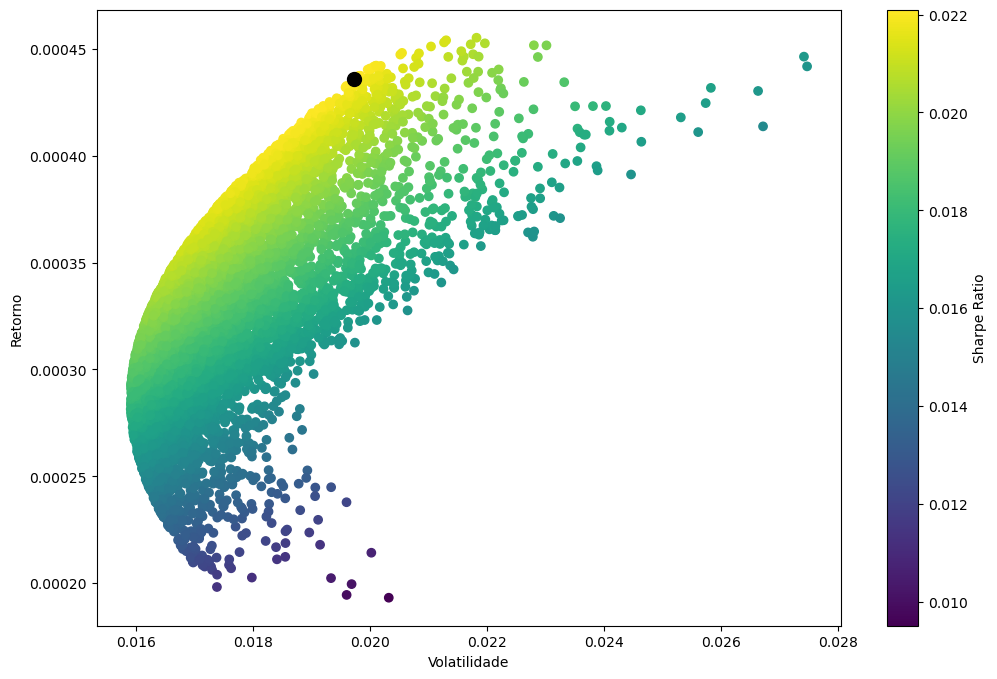

In [213]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(max_sr_vol, max_sr_ret,c='black', s=100) # black dot
plt.show()

Nós podemos ver no gráfico acima o conjunto de portfólios simulados, pois o peso $w_i$ de cada ativo foi simulado e criamos um conjunto de $n = 10000$ carteiras e escolhemos no ponto preto a que tem maior **Sharpe Ratio**, pelas razões explicadas anteriormente. Esse dado nos dá uma noção do portfólio ponderado pelo risco.

Com essas simulações, podemos fazer uma representação gráfica da Fronteira Eficiente. Para isso, tentaremos recuperar os pesos que retornam o máximo Índice de Sharpe para cada volatilidade, de forma que seja possível achar os pontos de menor volatilidade que tenham a maior taxa de retorno.

Pelo conceito, deveríamos achar a maior taxa de retorno para essa relação, mas não há uma forma computacional nas nossas bibliotecas que faça isso. Entretanto, a biblioteca `SciPy` possui uma função de otimização que permite achar os argumentos mínimos de uma função para se chegar a um determinado limite (`optimize.minimize`). Por essa razão, faremos o raciocínio inverso: calcularemos o Sharpe Ratio negativo, e idenficaremos quais pesos fazem com que a função obtenha o resultado esperado.

Abaixo definimos algumas funções de apoio para a otimização:

In [214]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights)
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov(), weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

E aqui, definimos os parâmetros da otimização:
- A soma dos pesos simulados deve dar 1, indicando que os pesos, somados, dão 100%
- Os pesos devem variar de 0 a 1
- O peso inicial de todas as carteiras é 0.2

In [215]:
cons = ({'type': 'eq', 'fun': check_sum})
bounds = ((0,1), (0,1), (0,1), (0,1))
init_guess = ((0.2),(0.2),(0.2),(0.2))

Com essas restrições definidas, é possível chamar a rotina de otimização:

In [216]:
op_results = optimize.minimize(neg_sharpe, init_guess, method="SLSQP", bounds= bounds, constraints=cons)
print(op_results)

     fun: -0.022116344491438282
     jac: array([ 1.72524480e-04,  2.99399253e-04, -3.33727803e-05, -4.38016839e-04])
 message: 'Optimization terminated successfully'
    nfev: 40
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.31553799, 0.01831863, 0.57299668, 0.09314671])


Para montagem do gráfico, criamos um espaço de 200 retornos que varia de -0,02% a 0,06%. Esses limites foram definidos com base no gráfico montado anteriormente:

In [217]:
frontier_y = np.linspace(0.0002, 0.0004, 200)

In [218]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

Com esse espaço de taxa de retornos, utilizaremos a função `minimize` para verificar quais conjuntos de pesos resultam na menor volatilidade possível para cada retorno, maximizando o Sharpe Ratio: 

In [219]:
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = optimize.minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

Com os dados em mãos, podemos plotar no gráfico o conjunto de dados de retorno x volatilidade que foi montado com essa simulação, identificando, assim, a Fronteira Eficiente.

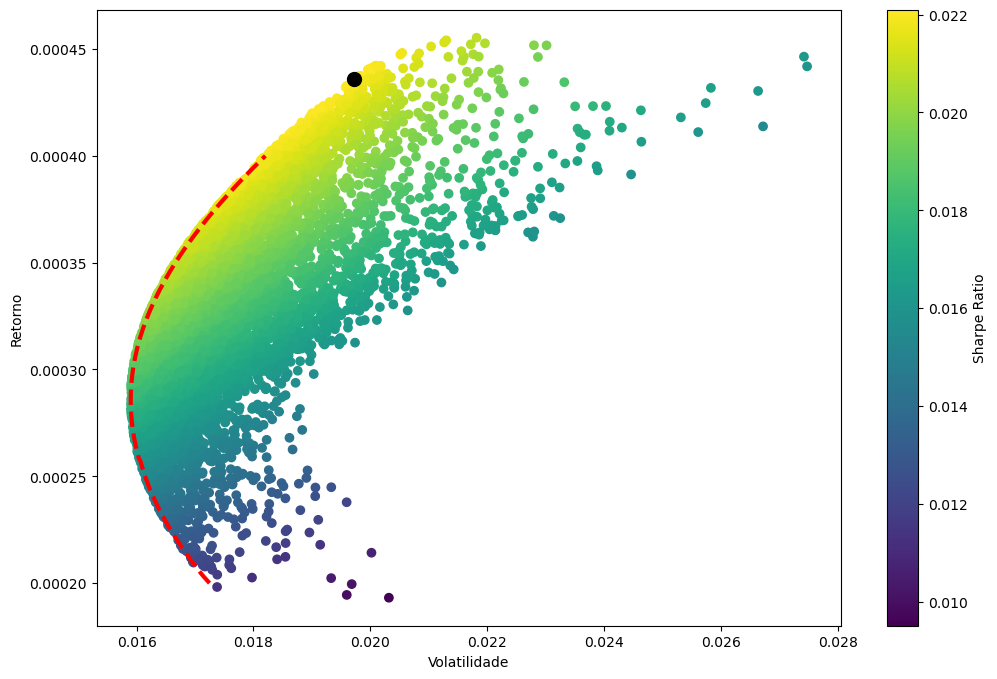

In [220]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.scatter(max_sr_vol, max_sr_ret,c='black', s=100)
# plt.savefig('cover.png')
plt.show()

Com os dados de retorno das ações em mãos, podemos checar como é a distribuição da carteira e do índice Bovespa. Essa informação é importante para que possamos realizar o teste de ANOVA:

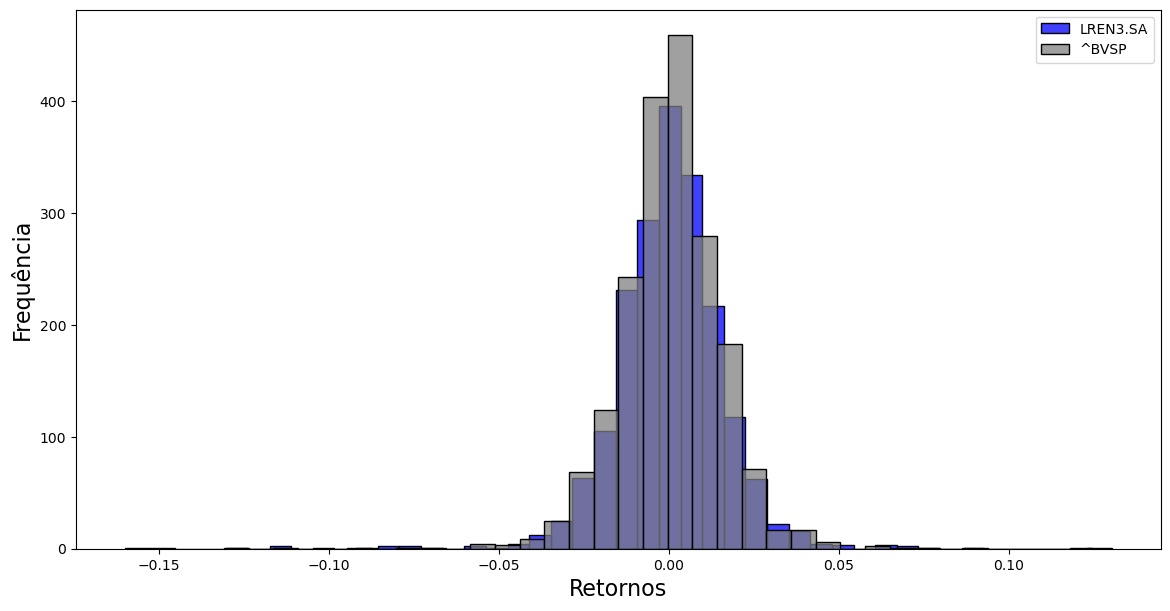

In [221]:
fig, ax = plt.subplots(figsize=(14,7))
# ax = sns.histplot(taxas_retorno_date['AMAR3.SA'], bins=40, label='AMAR3.SA', color = 'red')
# ax = sns.histplot(taxas_retorno_date['GUAR3.SA'], bins=40, label='GUAR3.SA', color='green')
# ax = sns.histplot(taxas_retorno_date['ARZZ3.SA'], bins=40, label='ARZZ3.SA', color='yellow')
ax = sns.histplot(taxas_retorno_date['CARTEIRA'], bins=40, label='LREN3.SA', color='blue')
ax = sns.histplot(taxas_retorno_date['^BVSP'], bins=40, label='^BVSP', color='gray')
ax.set_xlabel("Retornos",fontsize=16)
ax.set_ylabel("Frequência",fontsize=16)
plt.legend()

# Teste da variâncias homogêneas ou homocedasticidade

Uma das premissas para realizar o teste da ANOVA é que as variâncias das amostras sejam homogêneas, ou seja:

$$
\sigma _{1}^2 = \sigma _{2}^2 =... = \sigma _{n}^2
$$

Para isso, existem dois tipos de teste para verificar essa homocedasticidade: O Teste de Levene e o Teste de Barlet.


### Teste de Levene

O Teste de Levene é uma estatística inferencial usada para avaliar a igualdade de variâncias de uma variável calculada para dois ou mais grupos. Ele testa a hipótese nula de que as variâncias populacionais são iguais (chamada de homogeneidade de variância ou homocedasticidade). Se o valor-p resultante do teste de Levene for menor que algum nível de significância (normalmente 0,05), é improvável que as diferenças obtidas nas variâncias amostrais tenham ocorrido com base na amostragem aleatória de uma população com variâncias iguais. Assim, a hipótese nula de variâncias iguais é rejeitada e conclui-se que há diferença entre as variâncias na população.


Então, vamos verificar se as variâncias são iguais nas combinações dos ativos que compõem a carteira:

In [222]:
from scipy.stats import levene, bartlett, f, norm, f_oneway
nivel_significancia = 0.05

def getAmostra(ativo):
    return taxas_retorno_date[ativo]

def testaLevene(ativo1, ativo2):
    amostra1 = getAmostra(ativo1)
    amostra2 = getAmostra(ativo2)
    estatistica_teste, p_valor = levene(amostra1, amostra2)
    
    #print("Estatística-teste:",ativo1," x ", ativo2, estatistica_teste)
    #print("P-valor:", p_valor)
    teste = ativo1 + " x " + ativo2
    resultado = ""
    if p_valor <= nivel_significancia:
        resultado = "Rejeita H0 - Variâncias não são iguais"
    else:
        resultado = "Não Rejeita H0 - Variâncias são iguais"
    return (teste, p_valor.round(5), resultado)

resultadoTesteLevene = []
acoesTeste = acoes.copy()
for acaoLinha in acoesTeste:
    resultadoTesteLevene.append(testaLevene('CARTEIRA',acaoLinha))

resultadoTesteLeveneDf = pd.DataFrame(resultadoTesteLevene, columns=['Teste', 'P-value', 'Resultado']);
# resultadoDf.query("Resultado == 'Não Rejeita H0 - Variâncias são iguais'")
resultadoTesteLeveneDf.sort_values(by='P-value')

,Teste,P-value,Resultado
0,CARTEIRA x JBSS3.SA,0.00000,Rejeita H0 - Variâncias não são iguais
1,CARTEIRA x GRND3.SA,0.00000,Rejeita H0 - Variâncias não são iguais
2,CARTEIRA x TOTS3.SA,0.00000,Rejeita H0 - Variâncias não são iguais
3,CARTEIRA x ITUB4.SA,0.00000,Rejeita H0 - Variâncias não são iguais
4,CARTEIRA x ^BVSP,0.44309,Não Rejeita H0 - Variâncias são iguais


De forma gráfica, podemos verificar que a dispersão entre os ativos homocedásticos é muito similar, enquanto nos heterocedásticos, há uma dispersão maior:

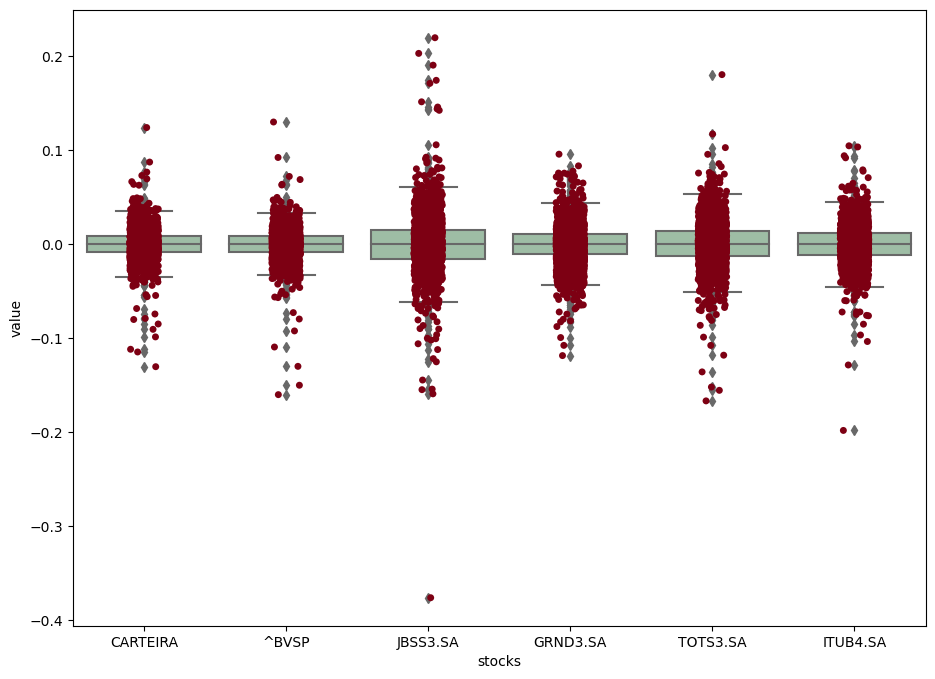

In [223]:
plt.figure(figsize =(11, 8))
df_melt = pd.melt(taxas_retorno_date.reset_index(), id_vars=['index'], value_vars=['CARTEIRA','^BVSP','JBSS3.SA','GRND3.SA','TOTS3.SA', 'ITUB4.SA'])
df_melt.columns = ['index', 'stocks', 'value']

ax = sns.boxplot(x='stocks', y='value', data=df_melt, color='#99c2a2')
ax = sns.stripplot(x="stocks", y="value", data=df_melt, color='#7d0013')
plt.show()

## Teste ANOVA

Uma vez que a condição de homogeneidade das variâncias foi satisfeita, podemos fazer o teste ANOVA, para identificar se a média das ações é igual. As hipóteses que serão verificadas serão as seguintes:


H_0: $$\mu _{0} = \mu _{1} = ... = \mu _{n}$$
H_1: Há diferença entre as médias

In [224]:
analise_df_melted = pd.melt(taxas_retorno_date, id_vars=["Date"], value_vars=["CARTEIRA", "^BVSP"])
analise_df_melted.columns = ["Data de Negociação", "Tipo", "Taxa de Retorno"]
analise_df_melted

,Data de Negociação,Tipo,Taxa de Retorno
0,2015-01-02,CARTEIRA,0.000000
1,2015-01-05,CARTEIRA,-0.009597
2,2015-01-06,CARTEIRA,-0.023272
3,2015-01-07,CARTEIRA,0.032969
4,2015-01-08,CARTEIRA,0.010429
...,...,...,...
3849,2022-09-26,^BVSP,-0.023567
3850,2022-09-27,^BVSP,-0.006787
3851,2022-09-28,^BVSP,0.000692
3852,2022-09-29,^BVSP,-0.007283


In [225]:
# Create ANOVA backbone table
data = [["Entre grupos", "", "", "", "", "", ""], ["Dentro dos grupos", "", "", "", "", "", ""], ["Total", "", "", "", "", "", ""]]
anova_table = pd.DataFrame(data, columns = ["Fonte da Variação", "SS", "df", "MS", "F", "P-value", "F crit"])
anova_table.set_index("Fonte da Variação", inplace = True)

# calculate SSTR and update anova table
x_bar = analise_df_melted["Taxa de Retorno"].mean()
SSTR = analise_df_melted.groupby("Tipo").count() * (analise_df_melted.groupby("Tipo").mean() - x_bar)**2
anova_table["SS"]["Entre grupos"] = SSTR["Taxa de Retorno"].sum()

# calculate SSE and update anova table
SSE = (analise_df_melted.groupby("Tipo").count() - 1) * analise_df_melted.groupby("Tipo").std()**2
anova_table["SS"]["Dentro dos grupos"] = SSE["Taxa de Retorno"].sum()

# calculate SSTR and update anova table
SSTR = SSTR["Taxa de Retorno"].sum() + SSE["Taxa de Retorno"].sum()
anova_table["SS"]["Total"] = SSTR

# update degree of freedom
anova_table["df"]["Entre grupos"] = analise_df_melted["Tipo"].nunique() - 1
anova_table["df"]["Dentro dos grupos"] = analise_df_melted.shape[0] - analise_df_melted["Tipo"].nunique()
anova_table["df"]["Total"] = analise_df_melted.shape[0] - 1

# calculate MS
anova_table["MS"] = anova_table["SS"] / anova_table["df"]

# calculate F
F = anova_table["MS"]["Entre grupos"] / anova_table["MS"]["Dentro dos grupos"]
anova_table["F"]["Entre grupos"] = F

# p-value
anova_table["P-value"]["Entre grupos"] = 1 - f.cdf(F, anova_table["df"]["Entre grupos"], anova_table["df"]["Dentro dos grupos"])

# F critical
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table["F crit"]["Entre grupos"] = f.ppf(1-alpha, anova_table["df"]["Entre grupos"], anova_table["df"]["Dentro dos grupos"])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Fonte da Variação,,,,,,
Entre grupos,0.000004,1,0.000004,0.014557,0.903972,5.027817
Dentro dos grupos,1.026242,3852,0.000266,,,
Total,1.026246,3853,0.000266,,,


In [226]:
stat_teste, p_valor = f_oneway(taxas_retorno_date["CARTEIRA"], taxas_retorno_date["^BVSP"])

if p_valor <= nivel_significancia:
    print("Rejeita H0 - Médias não são iguais")
else:
    print("Não Rejeita H0 - Médias são iguais")

Não Rejeita H0 - Médias são iguais


# Regressão Linear

A análise de regressão estuda a relação entre uma variável chamada variável dependente e outras variáveis chamadas variáveis independentes ou explanatórias. Com isso, tenta-se prever o valor da variável dependente através de valores conhecidos das variáveis explicativas.

A notação que define como essas duas variáveis se relacionam está expressa abaixo:

$$
Y_i = \beta_1 + \beta_2X_i + u_i
$$

Onde temos:

$Y_i$ - Variável Resposta ou dependente

$\beta_1$ - Intercepto populacional, ou coeficiente linear

$\beta_2$ - Inclinação populacional, ou coeficiente angular

$X_i$ - Variável Preditora ou independente

$u_i$ - Erro aleatório

Para nossa análise, vamos escolher a ação TOTS3.SA como variável dependente

## Inspeção gráfica dos dados

O primeiro passo para iniciar uma regressão linear é fazer a análise gráfica de como as variáveis se comportam. Isso é feito com o auxílio de um Histograma, que nos permitirá a visão da Curva de Bell da ITUB4.SA e do índice Bovespa:


Text(0.5, 0, 'Retorno da ITUB4.SA')

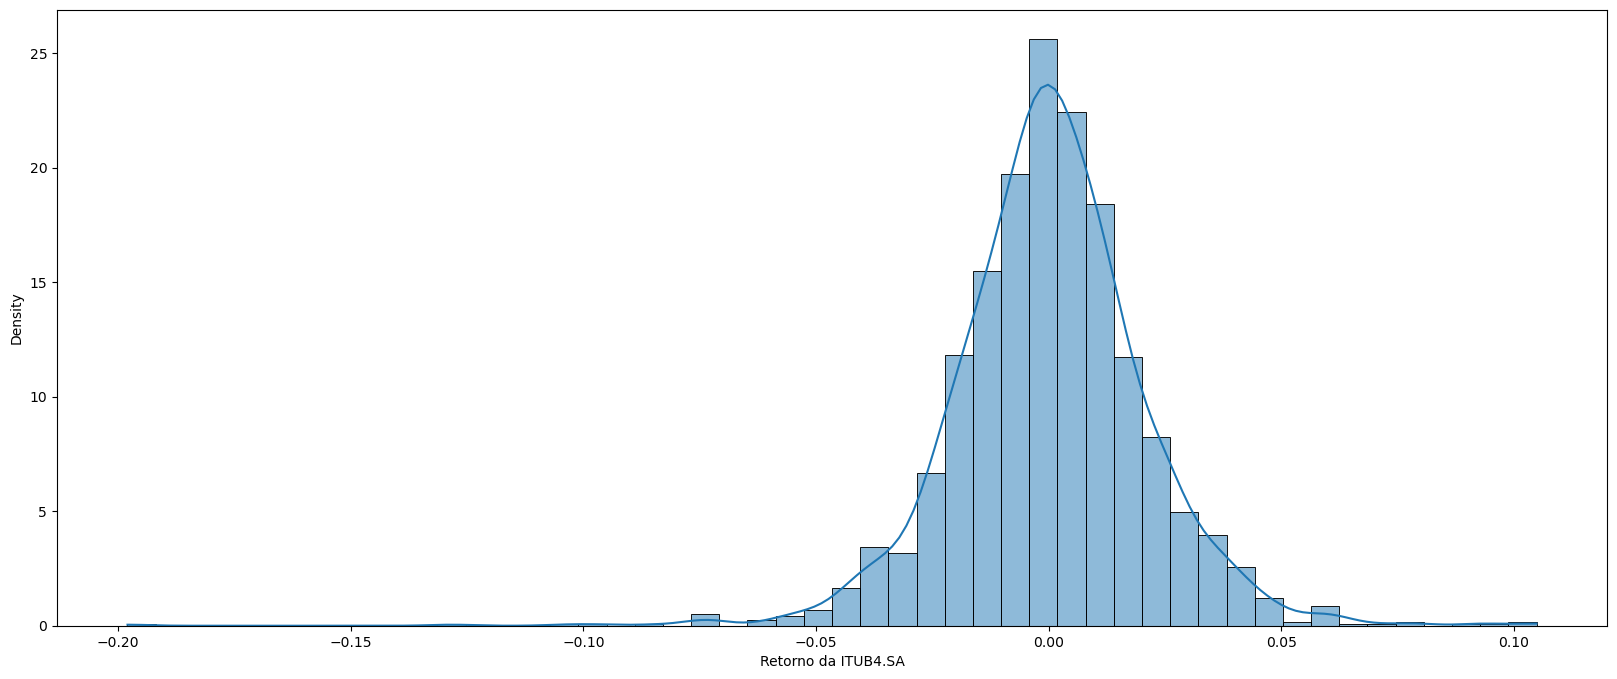

In [227]:
ax = sns.histplot(data=taxas_retorno_date["ITUB4.SA"], kde=True, stat="density", bins=50)
ax.figure.set_size_inches(20, 8)
ax.set_xlabel("Retorno da ITUB4.SA")

Text(0.5, 0, 'Retorno da Bovespa')

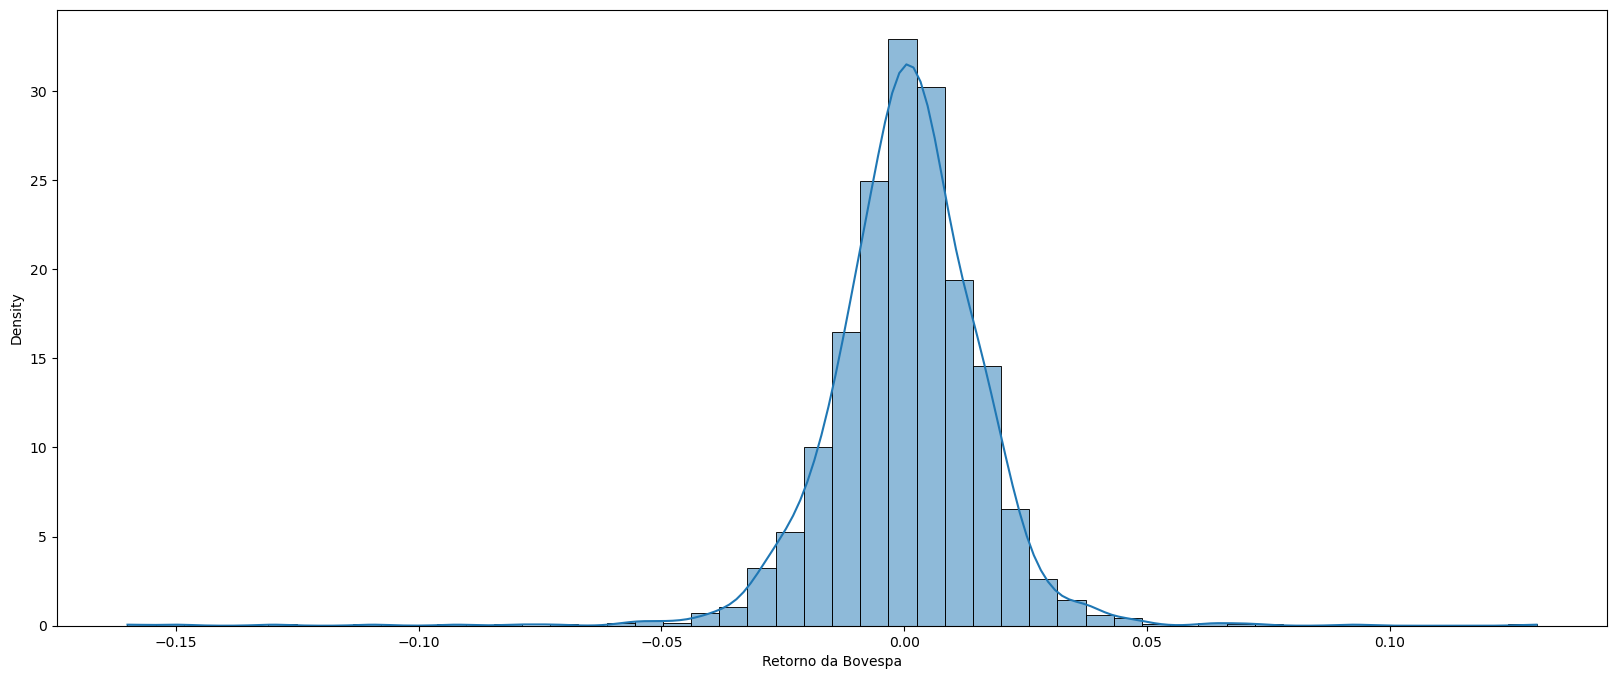

In [228]:
ax = sns.histplot(data=taxas_retorno_date["^BVSP"], kde=True, stat="density", bins=50)
ax.figure.set_size_inches(20, 8)
ax.set_xlabel("Retorno da Bovespa")

O Diagrama de Dispersão também oferece informações visuais do comportamento da Carteira em relação ao índice:

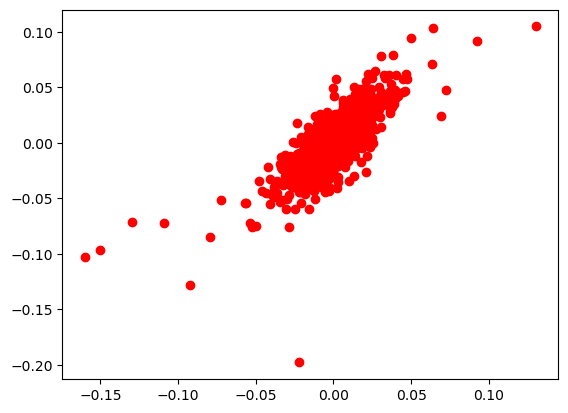

In [229]:
from turtle import color


plt.scatter(x = taxas_retorno_date['^BVSP'], y= taxas_retorno_date['ITUB4.SA'], color='red')

A partir daí, podemos traçar a relação linear que existe entre o IBOVESPA e a Totus:

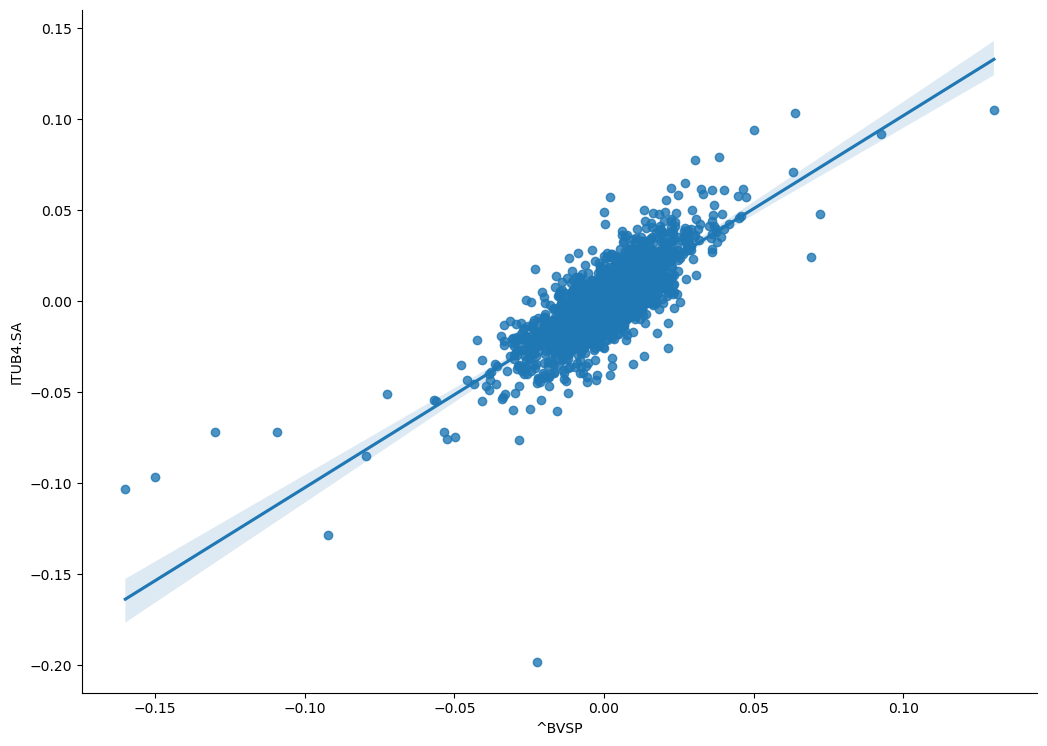

In [230]:
ax = sns.lmplot(x="^BVSP", y="ITUB4.SA", data=taxas_retorno_date)
ax.fig.set_size_inches(12, 8)

## Estimando os parâmetros do modelo de regressão

Uma das formas de identificar os parâmetros da regressão linear é através da técnica dos Mínimos Quadrados Ordinários. Ela procura encontrar o melhor ajuste para um conjunto de dados tentando minimizar a soma dos quadrados das diferenças entre o valor estimado e os dados observados (tais diferenças são chamadas resíduos).

Através dela, poderemos definir os valores dos coeficientes angulares e lineares que definimos na equação de regressão apresentada anteriormente, utilizando o índice Bovespa como variável explicativa, e a ITUB4 como variável resposta.


In [231]:
import statsmodels.formula.api as smf

dados_regressao =taxas_retorno_date.filter(["^BVSP","ITUB4.SA"])
dados_regressao.rename(columns={'^BVSP':'BVSP'}, inplace=True)
dados_regressao.rename(columns={'ITUB4.SA':'ITUB4'}, inplace=True)


regressao = smf.ols(data=dados_regressao, formula="ITUB4 ~ BVSP")
fit_model = regressao.fit()
print(fit_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  ITUB4   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     3315.
Date:                Sun, 02 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:18:54   Log-Likelihood:                 5684.3
No. Observations:                1927   AIC:                        -1.136e+04
Df Residuals:                    1925   BIC:                        -1.135e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0002      0.000     -0.652      0.5

Desta forma, podemos definir o valor do Intercepto ($\beta_1$) e da inclinação populacional ($\beta_2$) da equação:

In [232]:
beta_1 = fit_model.params[0]
beta_2 = fit_model.params[1]
print(f"Intercepto: {beta_1:0.6f}")
print(f"Inclinação populacional (BVSP): {beta_2:0.6f}")


Intercepto: -0.000188
Inclinação populacional (BVSP): 1.022272


## Diagnóstico do modelo

Vamos analisar o gráfico quantil-quantil para verificar como o resíduo, que é o erro entre o que foi predito e o que realmente aconteceu, se comporta no nosso modelo:

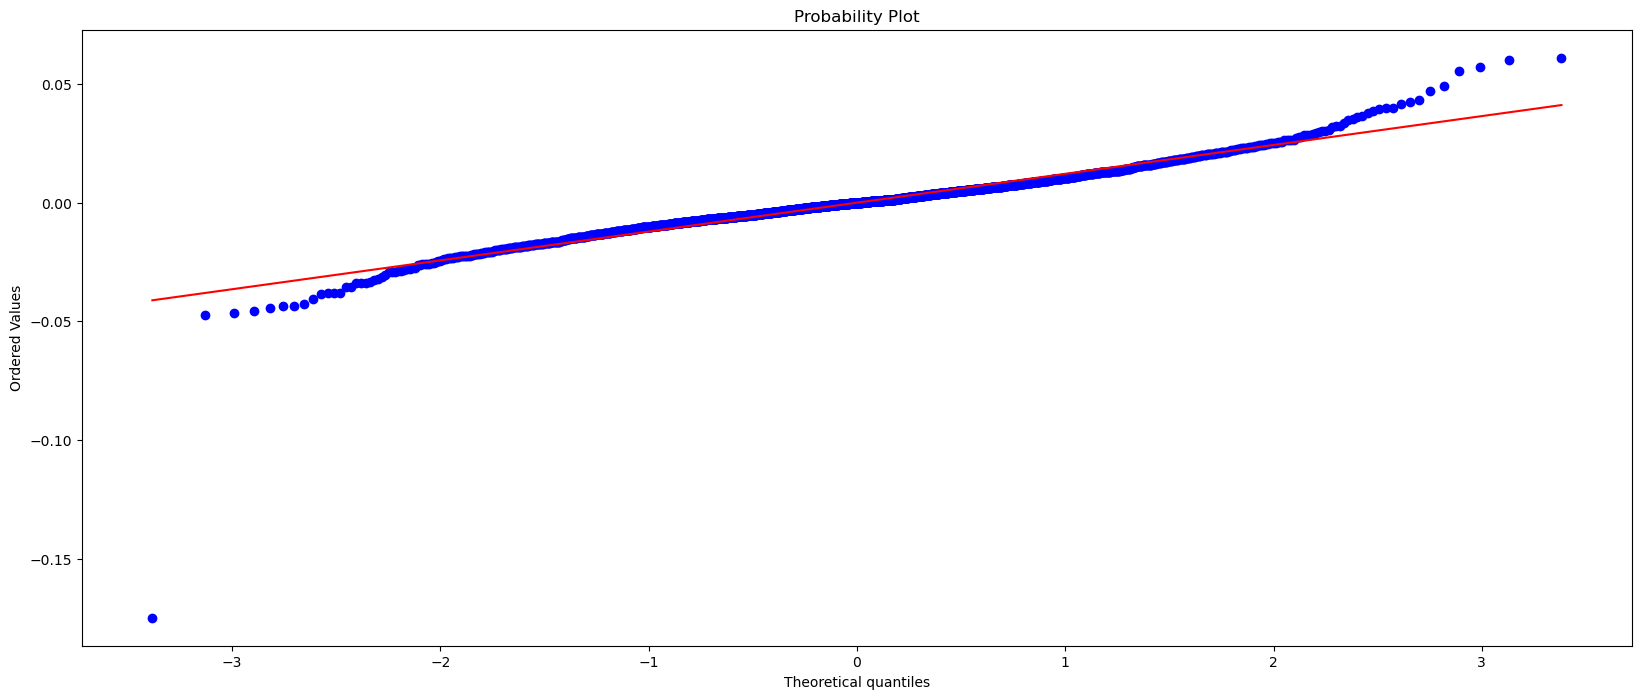

In [233]:
from scipy.stats import probplot

plt.figure(figsize=(20, 8))
(_, (_, _, _)) = probplot(fit_model.resid, plot=plt)

Convém também testar a normalidade do modelo, através da inspeção visual da distribuição:

<AxesSubplot:ylabel='Density'>

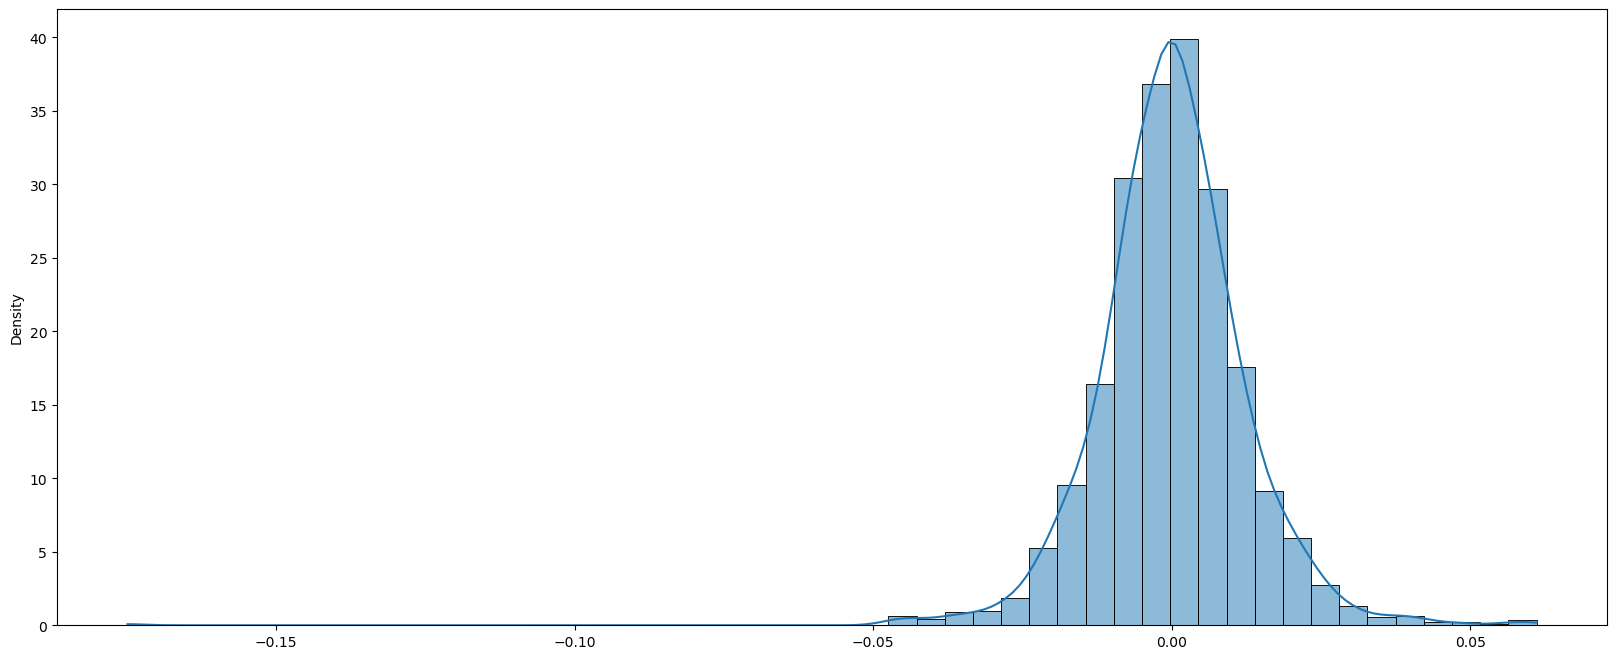

In [234]:
ax = sns.histplot(fit_model.resid, kde=True, stat="density", bins=50)
ax.figure.set_size_inches(20, 8)
ax

E o gráfico de espalhamento também nos dá uma versão visual de como esses dados se comportam em relação ao modelo de regressão:

<AxesSubplot:xlabel='Previsto', ylabel='Resíduos'>

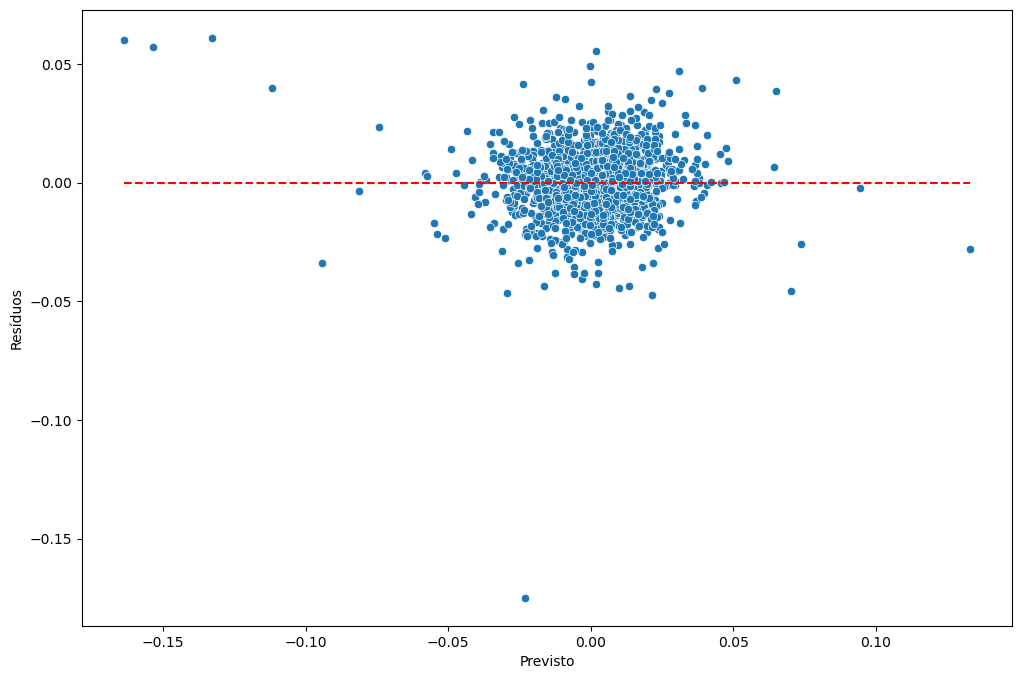

In [235]:
ax = sns.scatterplot(x=fit_model.fittedvalues, y=fit_model.resid)
ax.figure.set_size_inches(12, 8)
ax.hlines(y=0, xmin=fit_model.fittedvalues.min(),
 xmax = fit_model.fittedvalues.max(), colors='red',
 linestyles='dashed')
ax.set_xlabel('Previsto')
ax.set_ylabel('Resíduos')
ax

Finalmente, podemos utilizar os coeficientes encontrados anteriormente para plotar a equação de Regressão Linear:

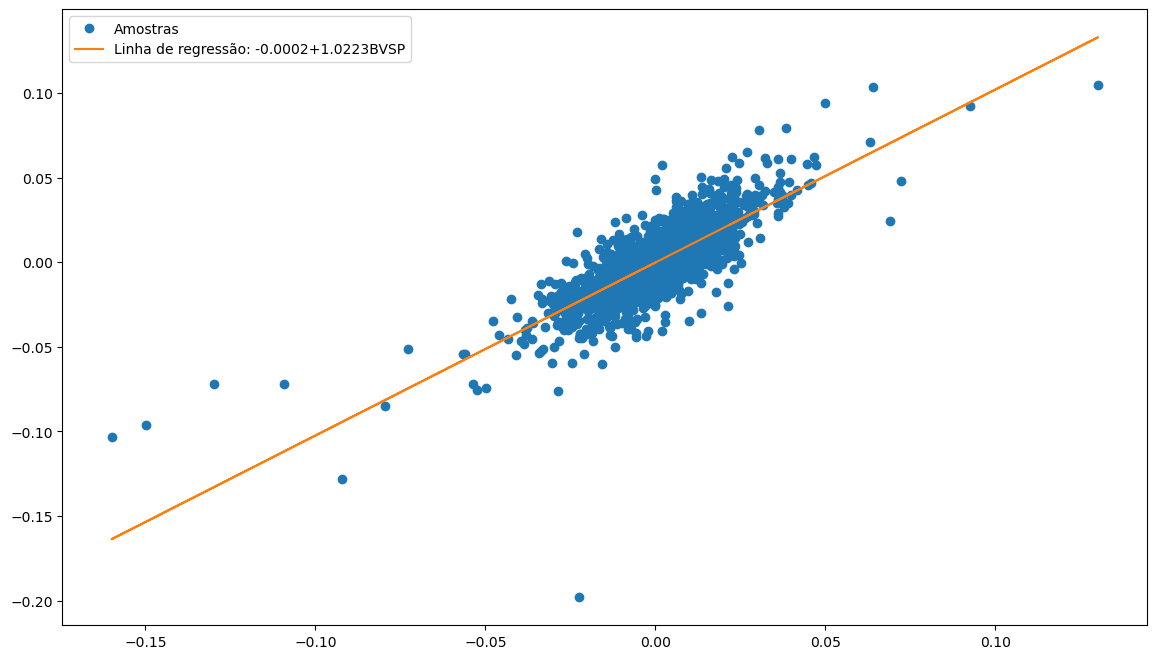

In [236]:
x_bovespa = dados_regressao['BVSP']
y_itbu = dados_regressao['ITUB4']
plt.figure(figsize=(14,8))
plt.plot(x_bovespa, y_itbu,'o')
plt.plot(x_bovespa, beta_1 + beta_2*x_bovespa )
equacao_regressao = "{:.4f}".format(beta_1) + '+' + "{:.4f}".format(beta_2) +'BVSP'
plt.legend(['Amostras','Linha de regressão: ' + equacao_regressao])

# Modelo de Machine Learning

Com os dados históricos das ações, é possível treinar um modelo de Machine Learning que tenta predizer qual o comportamente de um ativo em relação a outro. No nosso estudo, utilizaremos o TensorFlow, que é uma biblioteca de código aberto desenvolvida pelo Google em 2015. Ele utiliza o paradigma de redes neurais para executar o aprendizado.


In [237]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import deque

import os
import numpy as np
import pandas as pd
import random

RANDOM_STATE = 314
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

Vamos criar o dataset que será utilizado como treinamento, onde os dados da variável explicativa serão as taxas de retorno do índice Bovespa, que utilizaremos para tentar predizer o comportamento da ITUB4

In [238]:
X = taxas_retorno_date['^BVSP']
y = taxas_retorno_date['ITUB4.SA']

A biblioteca Scikit-Learn nos permite dividir os dados de treinamento e teste. No nosso caso, utilizaremos a proporção 70/30, ou seja: 70% dos dados serão de treino, e 30% para testes



In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
X_train


967     0.029139
1107   -0.007459
1193    0.008889
860    -0.008725
913    -0.005881
          ...   
1066    0.013340
854    -0.025176
1737    0.006844
1645   -0.010764
520     0.003214
Name: ^BVSP, Length: 1348, dtype: float64

Agora definiremos o modelo de rede neural que fará o aprendizado. Ele corresponde a uma camada Dense com 1 neurônio. Também estabelecemos o número de passos que ele será treinado e retorna como saída um valor que seria o preço predito da ação

In [241]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

Agora faremos a inicialização dos parâmetros para executar o treinamento do nosso modelo:

In [242]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 1
# Lookup step, 1 is the next day
LOOKUP_STEP = 15
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["^BVSP"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 50
# Amazon stock market
ticker = "ITUB4"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [243]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [244]:
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 2.3304e-04 - mean_absolute_error: 0.0156
Epoch 1: val_loss improved from inf to 0.00019, saving model to results\2022-10-02_ITUB4-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-1-step-15-layers-2-units-256.h5
22/22 [==============================] - 29s 457ms/step - loss: 2.3304e-04 - mean_absolute_error: 0.0156 - val_loss: 1.9215e-04 - val_mean_absolute_error: 0.0145
Epoch 2/50
21/22 [===========================>..] - ETA: 0s - loss: 2.1892e-04 - mean_absolute_error: 0.0150
Epoch 2: val_loss improved from 0.00019 to 0.00018, saving model to results\2022-10-02_ITUB4-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-1-step-15-layers-2-units-256.h5
22/22 [==============================] - 1s 38ms/step - loss: 2.1873e-04 - mean_absolute_error: 0.0150 - val_loss: 1.8484e-04 - val_mean_absolute_error: 0.0147
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 2.1176e-04 - mean_absolute_error: 0.0147
Epoch 3: val_loss did n

Agora vamos analisar como foi a performance do treino, analisando as curvas de perda e do erro absoluto:

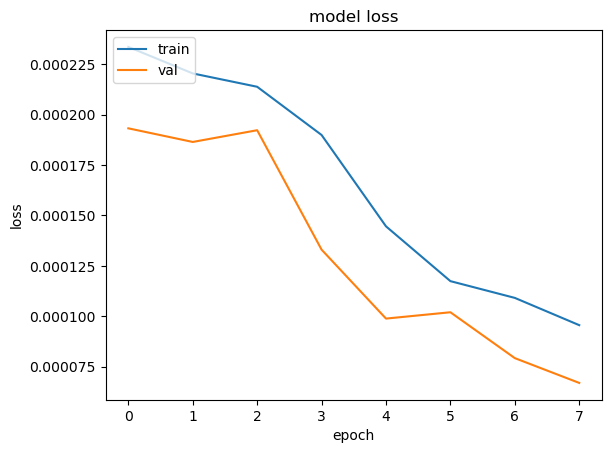

In [252]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_loss(history)

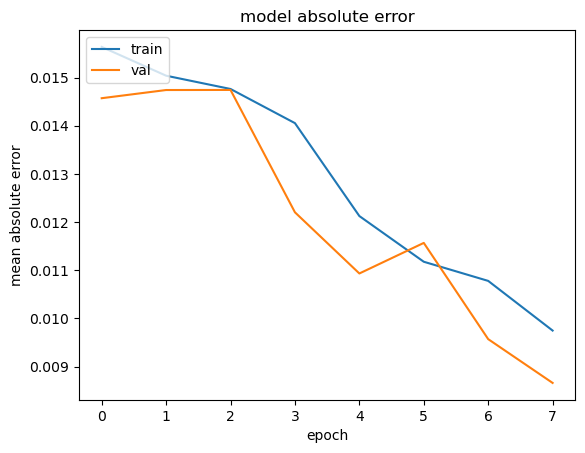

In [253]:
def plot_mean_absolute_error(history):
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('model absolute error')
    plt.ylabel('mean absolute error')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_mean_absolute_error(history)

Podemos verificar que o modelo tem sua melhor performance em torno de 8 épocas de aprendizagem. Depois o erro aumenta e passa a cair novamente, repetindo esse ciclo. Esse efeito deve ser evitado para que não ocorra um overfitting. Vammos treinar o modelo novamente com esse número de épocas

In [251]:
N_STEPS = 1
EPOCHS = 8
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)
                

Epoch 1/8
21/22 [===========================>..] - ETA: 0s - loss: 2.3356e-04 - mean_absolute_error: 0.0156
Epoch 1: val_loss improved from inf to 0.00019, saving model to results\2022-10-02_ITUB4-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-1-step-15-layers-2-units-256.h5
22/22 [==============================] - 24s 252ms/step - loss: 2.3357e-04 - mean_absolute_error: 0.0156 - val_loss: 1.9320e-04 - val_mean_absolute_error: 0.0146
Epoch 2/8
21/22 [===========================>..] - ETA: 0s - loss: 2.2061e-04 - mean_absolute_error: 0.0150
Epoch 2: val_loss improved from 0.00019 to 0.00019, saving model to results\2022-10-02_ITUB4-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-1-step-15-layers-2-units-256.h5
22/22 [==============================] - 1s 35ms/step - loss: 2.2043e-04 - mean_absolute_error: 0.0150 - val_loss: 1.8645e-04 - val_mean_absolute_error: 0.0147
Epoch 3/8
21/22 [===========================>..] - ETA: 0s - loss: 2.1425e-04 - mean_absolute_error: 0.0148
Epoch 3: val_loss did not 

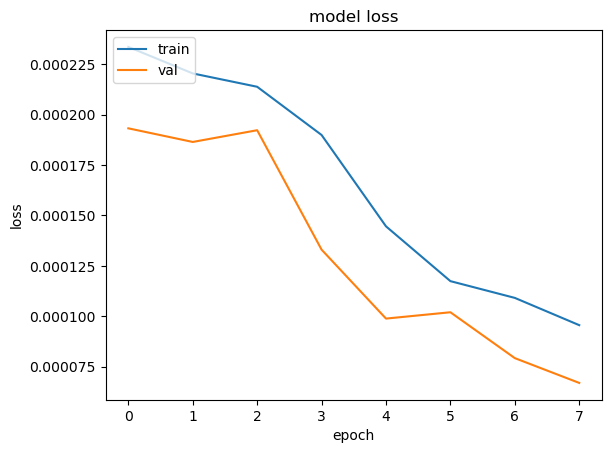

In [254]:
plot_loss(history)

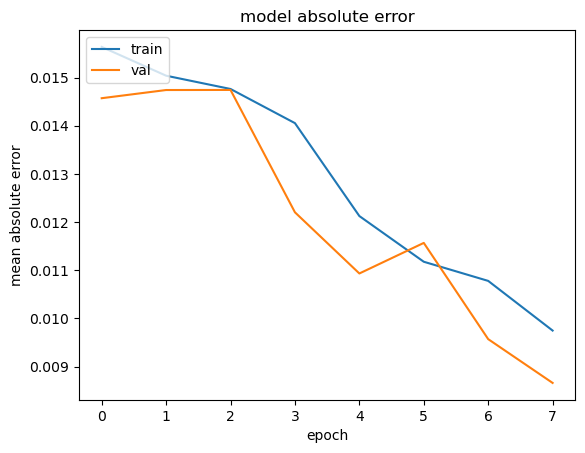

In [255]:
plot_mean_absolute_error(history)

Com o modelo calibrado, vamos fazer a predição dos dados de retorno do ITUB4 utilizando como entrada os índices Bovespa do nosso treinamento:

In [256]:
y_itub_previsto = model.predict(X)
y_itub_previsto

61/61 [==============================] - 6s 6ms/step


array([[ 0.00108358],
       [-0.02025644],
       [ 0.01151859],
       ...,
       [ 0.00179592],
       [-0.00641606],
       [ 0.023531  ]], dtype=float32)

Vamos acrescentar a coluna no dataset que contém as outras taxas de retorno para compararmos:

In [259]:
taxas_retorno_com_predicao = taxas_retorno_date[['Date', 'ITUB4.SA']]
taxas_retorno_com_predicao['ITUB4 PREVISTO'] = y_itub_previsto
taxas_retorno_com_predicao.head()

C:\Users\demet\AppData\Local\Temp\ipykernel_12028\4001931080.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,ITUB4.SA,ITUB4 PREVISTO
0,2015-01-02,0.000000,0.001084
1,2015-01-05,0.005013,-0.020256
2,2015-01-06,0.016047,0.011519
3,2015-01-07,0.035540,0.031975
4,2015-01-08,0.015521,0.011028


E podemos fazer a comparação gráfica do retorno predito com o real:

In [261]:
figuraComparacaoPredito = px.line(title = 'Comparação de retorno ITUB real x ITUB predito')
for i in taxas_retorno_com_predicao.columns[1:]:
  figuraComparacaoPredito.add_scatter(x = taxas_retorno_com_predicao["Date"] ,y = taxas_retorno_com_predicao[i], name = i)
figuraComparacaoPredito.add_hline(y = taxas_retorno_com_predicao['ITUB4.SA'].mean(), line_color="green", line_dash="dot", )
figuraComparacaoPredito.show()